In [1]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics
import swifter
import matplotlib as plt

In [2]:
df1 = pickle.load(open("Dumps/oc_propdf.sav", "rb"))
df2 = pickle.load(open("Dumps/oac_propdf.sav", "rb"))

In [3]:
print(df1["time_const"].min())
print(df2["time_const"].min())

728206
728206


In [4]:
df1["time_const"] = df1["time_const"]-728175
df2["time_const"] = df2["time_const"]-728175

In [5]:
df1['avg'] = df1.groupby(["outcode","year","month","property_type"])['price'].transform('mean')
df2['avg'] = df2.groupby(["outcode","year","month","property_type"])['price'].transform('mean')

In [6]:
print(df1.isna().sum())
df1 = df1.dropna()
df2 = df2.dropna()

price            0
property_type    0
year             0
month            0
day              0
outcode          0
time_const       0
avg              0
dtype: int64


In [7]:
# Adding average growth values for df1
df1 = df1.sort_values(["year", "month"])

df1["p_avg"] = df1.groupby(["property_type", "outcode"])["avg"].shift(1)
df1["growth"] = (df1["avg"]-df1["p_avg"])

avg_growth = df1.groupby(['property_type', 'outcode'])['growth'].mean().reset_index()
avg_growth.rename(columns={'growth': 'avg_growth'}, inplace=True)

df1 = pd.merge(df1, avg_growth, on=['property_type', 'outcode'], how='left')

# Adding average growth values for df2
df2 = df2.sort_values(["year", "month"])

df2["p_avg"] = df2.groupby(["property_type", "outcode"])["avg"].shift(1)
df2["growth"] = (df2["avg"]-df2["p_avg"])

avg_growth = df2.groupby(['property_type', 'outcode'])['growth'].mean().reset_index()
avg_growth.rename(columns={'growth': 'avg_growth'}, inplace=True)

df2 = pd.merge(df2, avg_growth, on=['property_type', 'outcode'], how='left')

df2

,price,property_type,year,month,day,outcode,time_const,avg,p_avg,growth,avg_growth
0,59995,0,1995,1,20,211,50,81495.555556,NaN,NaN,34.881834
1,76000,0,1995,1,18,479,48,104020.050000,NaN,NaN,6.100440
2,75000,3,1995,1,4,298,34,66530.937500,NaN,NaN,66.996720
3,59500,0,1995,1,6,854,36,78154.166667,NaN,NaN,20.270103
4,85550,0,1995,1,26,826,56,98590.740741,NaN,NaN,29.567578
...,...,...,...,...,...,...,...,...,...,...,...
13304454,155000,4,2017,6,9,114,8219,201312.500000,201312.500000,0.0,27.190147
13304455,220000,4,2017,6,2,113,8212,219643.833333,219643.833333,0.0,37.968835
13304456,247000,4,2017,6,16,114,8226,201312.500000,201312.500000,0.0,27.190147
13304457,345000,0,2017,6,22,152,8232,392666.625000,392666.625000,0.0,51.198447


In [8]:
# Getting X and Y frames from original data
X_oc = df1[["time_const", "year", "property_type", "outcode", "avg", "avg_growth"]]
Y_oc = df1[["price"]] 

X_oac = df2[["time_const", "year", "property_type", "outcode", "avg", "avg_growth"]]
Y_oac = df2[["price"]]

In [9]:
# Getting OC test/train split
X_oc_train, X_oc_test, y_oc_train, y_oc_test = train_test_split(X_oc, Y_oc, test_size=0.2, random_state=42)

print("Out Code Test/Train Lengths")
print(len(X_oc_train))
print(len(y_oc_train))
print()
print(len(X_oc_test))
print(len(y_oc_test))

print()

# Getting OAC test/train split
X_oac_train, X_oac_test, y_oac_train, y_oac_test = train_test_split(X_oac, Y_oac, test_size=0.2, random_state=42)
print("Out/Area Code Test/Train Lengths")
print(len(X_oac_train))
print(len(y_oac_train))
print()
print(len(X_oac_test))
print(len(y_oac_test))

Out Code Test/Train Lengths
8103351
8103351

2025838
2025838

Out/Area Code Test/Train Lengths
10643567
10643567

2660892
2660892


In [10]:
# OC
oc_model = XGBRegressor(colsample_bytree=1, 
                     gamma=3, 
                     learning_rate=0.1, 
                     max_depth=12, 
                     reg_alpha=0.01, 
                     reg_lambda=0.01)

oc_model.fit(X_oc_train, y_oc_train, 
              early_stopping_rounds=10, 
              eval_set=[(X_oc_test, y_oc_test)], 
              verbose=False)

oc_check = oc_model.predict(X_oc_test)

oc_mae = sklearn.metrics.mean_absolute_error(y_oc_test, oc_check)

print(oc_mae)

# OAC
oac_model = XGBRegressor(colsample_bytree=1, 
                     gamma=4, 
                     learning_rate=0.1, 
                     max_depth=15, 
                     reg_alpha=0.01, 
                     reg_lambda=0.1)

oac_model.fit(X_oac_train, y_oac_train, 
              early_stopping_rounds=10, 
              eval_set=[(X_oac_test, y_oac_test)], 
              verbose=False)

oac_check = oac_model.predict(X_oac_test)

oac_mae = sklearn.metrics.mean_absolute_error(y_oac_test, oac_check)

print(oac_mae)

c:\Users\camer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


75488.8413401297


c:\Users\camer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


46806.71262284737


In [11]:
pickle.dump(oc_model, open("Dumps/oc_test.sav", "wb"))
pickle.dump(oac_model, open("Dumps/oac_test.sav", "wb"))

Text(0, 0.5, 'Value')

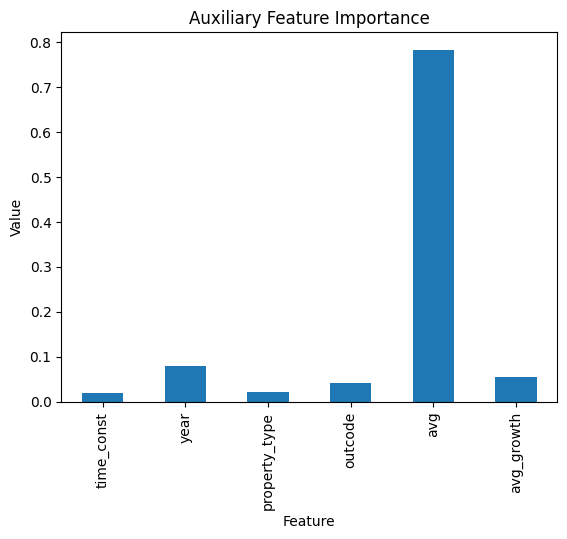

In [12]:
frame1 = pd.DataFrame(oc_model.feature_importances_, index=oc_model.feature_names_in_)
frame1
fig1 = frame1.plot(kind="bar", legend=False)
fig1.set_title("Auxiliary Feature Importance")
fig1.set_xlabel("Feature")
fig1.set_ylabel("Value")

Text(0, 0.5, 'Value')

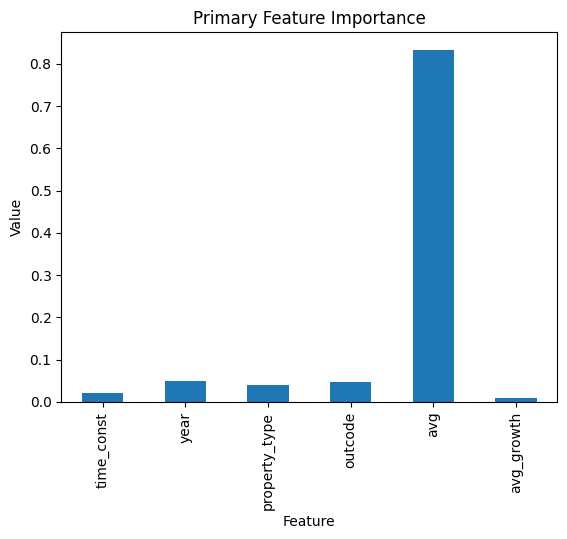

In [13]:
frame1 = pd.DataFrame(oac_model.feature_importances_, index=oac_model.feature_names_in_)
frame1
fig1 = frame1.plot(kind="bar", legend=False)
fig1.set_title("Primary Feature Importance")
fig1.set_xlabel("Feature")
fig1.set_ylabel("Value")

In [14]:
print("Primary Auxiliary Feature Importance")
print(oc_model.feature_names_in_)
print(oc_model.feature_importances_)

print("Primary Primary Feature Importance")
print(oc_model.feature_names_in_)
print(oac_model.feature_importances_)

Primary Auxiliary Feature Importance
['time_const' 'year' 'property_type' 'outcode' 'avg' 'avg_growth']
[0.01956397 0.0796833  0.02150949 0.04090071 0.78255063 0.05579186]
Primary Primary Feature Importance
['time_const' 'year' 'property_type' 'outcode' 'avg' 'avg_growth']
[0.02168555 0.04831341 0.0408902  0.0475655  0.83313626 0.00840911]


In [15]:
dct1 = df1.groupby(["outcode", "property_type"])["avg_growth"].mean().to_dict()
dct2 = df2.groupby(["outcode", "property_type"])["avg_growth"].mean().to_dict()
print(dct1)
print(dct2)

{(0, 0): 100.948712341671, (0, 1): 55.233430596081696, (0, 2): 5602.906976744186, (0, 3): 113.64712975324059, (0, 4): 77.53284542809276, (1, 0): 8.696810649265851, (1, 1): 1.7055492341534637, (1, 2): 41.85243037974634, (1, 3): 1.2446279167399688, (1, 4): 0.8750009126018828, (2, 0): 68.27560417293897, (2, 1): 16.072138822914418, (2, 2): 2773.0495495495497, (2, 3): 24.03582872913199, (2, 4): 14.890090821748384, (3, 0): 17.48986920092872, (3, 1): 57.81630170316301, (3, 2): -4516.129032258061, (3, 3): 10.289351430547466, (3, 4): 2.7271462789712317, (4, 0): 10.277177855447112, (4, 1): 4.833135470254583, (4, 2): 31.882754994742328, (4, 3): 1.586865914608152, (4, 4): 1.0691281171603577, (5, 0): 9.796229310516475, (5, 1): 2.795294954839198, (5, 2): 1562.6344086021475, (5, 3): 17.26304645528284, (5, 4): 28.31889354247077, (6, 0): 12.856273744911805, (6, 1): 8.830576596073582, (6, 2): 173.87580299785793, (6, 3): 3.040175279433197, (6, 4): 1.7698042719538754, (7, 0): 41.019481485488626, (7, 1): 6

In [16]:
pickle.dump(dct1, open("Dumps/dct/oc_growth_dct.sav", "wb"))
pickle.dump(dct2, open("Dumps/dct/oac_growth_dct.sav", "wb"))

In [17]:
dct1 = df1.groupby(["outcode", "property_type"])["avg"].last().to_dict()
dct2 = df2.groupby(["outcode", "property_type"])["avg"].last().to_dict()
print(dct1)
print(dct2)

{(0, 0): 638017.6470588235, (0, 1): 330510.0, (0, 2): 963900.0, (0, 3): 554818.1818181818, (0, 4): 478681.8181818182, (1, 0): 370436.36363636365, (1, 1): 131980.46875, (1, 2): 432584.84, (1, 3): 191844.640625, (1, 4): 157330.6294117647, (2, 0): 672666.6666666666, (2, 1): 271292.85714285716, (2, 2): 927500.0, (2, 3): 321150.0, (2, 4): 330452.8095238095, (3, 0): 242100.0, (3, 1): 103000.0, (3, 2): 70000.0, (3, 3): 180085.29411764705, (3, 4): 99982.78571428571, (4, 0): 248028.125, (4, 1): 69680.0, (4, 2): 60427.333333333336, (4, 3): 116610.0, (4, 4): 94680.05172413793, (5, 0): 419259.94444444444, (5, 1): 187189.04109589042, (5, 2): 626250.0, (5, 3): 273395.13636363635, (5, 4): 274323.3333333333, (6, 0): 317476.36363636365, (6, 1): 97750.0, (6, 2): 131200.0, (6, 3): 139487.03703703705, (6, 4): 112178.88888888889, (7, 0): 515656.25, (7, 1): 293697.14285714284, (7, 2): 622875.0, (7, 3): 407478.8461538461, (7, 4): 433035.96, (8, 0): 954200.0, (8, 1): 298076.92307692306, (8, 2): 1926500.0, (8,

In [18]:
pickle.dump(dct1, open("Dumps/dct/oc_lastavg_dct.sav", "wb"))
pickle.dump(dct2, open("Dumps/dct/oac_lastavg_dct.sav", "wb"))